# Beer Recommendation
Fall 2018, 4571 Recommendation System Final Project


##### Background
For this project, we pretend to be an online craft beer retailer. We want to develop an algorithm to make purchase recommendations to our customers when they visit our website. The recommendations should be personalized based on the customer’s taste and preferences while helping customers discover new beers they have not tried before. We are imagining each user will have up to 10 Unranked recommended items each time they visit our website.


##### Challenges
Our project will focus on tackling the following challenges
- How can we build recommendations that take into account user preferences and taste?
- How do we ensure that there is enough variety among the set of beers that are recommended during each user session?
- How do we encourage users to explore beers/styles that they have not tried before - either because they are newly released items (not many reviews) or because they are a different type than the one usually consumed by the user? (serendipitous recommendations/novelty items)
- How do we provide recommendations for users that just joined the service? (cold start problem)
- How do we ensure that the model is adaptable to new features? 


##### In short:
- Scalability: compare the performance of different algorithms among users/items with different number of reviews
- Seredipity:
- Cold start:
- add more here....



##### Approach
(I think we need to have this cell updated)

Our recommendations will be based on a number of different approaches, each of them targeting to one of more business challenges
- Collaborative filtering/model based methods (targeting challenge #1)
- Popular items (#3, #4)
- Item based features (#2, #3)
- User Preferences (#4)

The goal is to combine these elements into an parallel ensemble /mixed (#5) methods that can provide quality predictions for different user groups.


##### Data Source
- Data source: the BeerAdvocate dataset of beer reviews 
- We pretend that the data represents reviews given by our user base after trying different beers. Each entry in the dataset includes information such as userID, beerID, ratings (aroma, appearance, overall, etc) from 1 to 5, and review text.


## Part 1: Data Preprocessing

In [1]:
# based on Google Colab 
# python 3
!pip install scikit-surprise

    100% |████████████████████████████████| 3.3MB 9.3MB/s 
  Running setup.py bdist_wheel for scikit-surprise ... - \ | / - \ | / - \ | / - done
  Stored in directory: /root/.cache/pip/wheels/ec/c0/55/3a28eab06b53c220015063ebbdb81213cd3dcbb72c088251ec
Successfully built scikit-surprise


In [0]:
import pandas as pd
import numpy as np
import os
import itertools as it
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from matplotlib.ticker import FormatStrFormatter
from surprise.model_selection import train_test_split
from surprise import NMF, Reader, Dataset, SVD, NMF, accuracy, KNNWithMeans

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### 1.1 Load Data

In [0]:
# load metadata from Google Drive 
# save as a list
data = []
one_complete_review = []

with open('/content/gdrive/My Drive/beeradvocate.txt', 'r') as f:
  for i in f: 
    #row = i.decode(encoding = 'UTF-8',errors = 'ignore')
    row = i.replace('beer/', 'beer_').replace('review/','review_') 
    if row == '\n':
      data.append(one_complete_review)
      one_complete_review = []
      continue
    row = row.split(": ", 1)[1].rstrip()
    one_complete_review.append(row)

In [0]:
# convert list to dataframe
column_names = ['beer_name', 'beer_beerId', 'beer_brewer', 'beer_ABV', 'beer_style', 
                'review_appearance', 'review_aroma', 'review_palate', 'review_taste', 
                'review_overall', 'review_time', 'review_profileName', 'review_text']

df = pd.DataFrame.from_records(data, columns=column_names)

In [6]:
# descriptive 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
beer_name             1586614 non-null object
beer_beerId           1586614 non-null object
beer_brewer           1586614 non-null object
beer_ABV              1586614 non-null object
beer_style            1586614 non-null object
review_appearance     1586614 non-null object
review_aroma          1586614 non-null object
review_palate         1586614 non-null object
review_taste          1586614 non-null object
review_overall        1586614 non-null object
review_time           1586614 non-null object
review_profileName    1586614 non-null object
review_text           1586614 non-null object
dtypes: object(13)
memory usage: 157.4+ MB


In [7]:
df.head(3)

,beer_name,beer_beerId,beer_brewer,beer_ABV,beer_style,review_appearance,review_aroma,review_palate,review_taste,review_overall,review_time,review_profileName,review_text
0,Sausa Weizen,47986,10325,5.00,Hefeweizen,2.5,2,1.5,1.5,1.5,1234817823,stcules,A lot of foam. But a lot.\tIn the smell some b...
1,Red Moon,48213,10325,6.20,English Strong Ale,3,2.5,3,3,3,1235915097,stcules,"Dark red color, light beige foam, average.\tIn..."
2,Black Horse Black Beer,48215,10325,6.50,Foreign / Export Stout,3,2.5,3,3,3,1235916604,stcules,"Almost totally black. Beige foam, quite compac..."


In [8]:
print('The full dataset includes:')
print('%d unique beers;' % df.beer_beerId.nunique())
print('%d unique users;' % df.review_profileName.nunique())
print('and %d reviews in total.' % df.shape[0])

The full dataset includes:
66055 unique beers;
33388 unique users;
and 1586614 reviews in total.


### 1.2 Exploratory Data Analysis

#### users

In [0]:
num_review_byuser = df.review_profileName.value_counts()
freq_list_user = np.array(list(dict(num_review_byuser).values()))

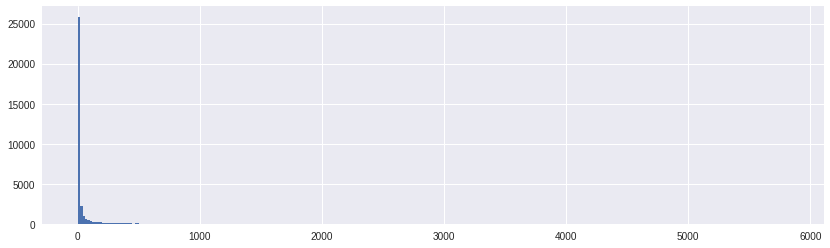

In [10]:
plt.figure(figsize=(14, 4))
plt.hist(freq_list_user, bins=300)
plt.show()

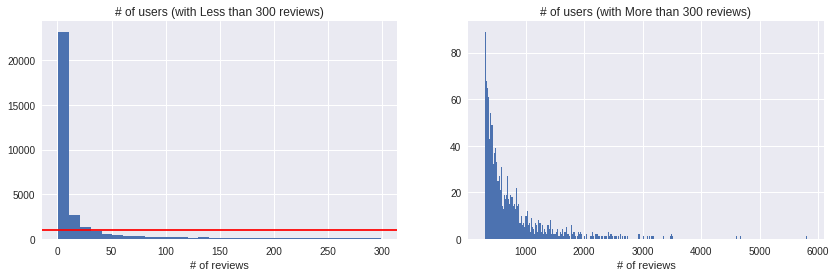

In [11]:
user5more = freq_list_user[np.where(freq_list_user >= 300)]
user5less = freq_list_user[np.where(freq_list_user < 300)]

plt.figure(figsize=(14, 4))

plt.subplot(121)
plt.hist(user5less, bins=30)
plt.title('# of users (with Less than 300 reviews)')
plt.xlabel('# of reviews')
plt.axhline(y=1000, color='r', linestyle='-')

plt.subplot(122)
plt.hist(user5more, bins=300)
plt.title('# of users (with More than 300 reviews)')
plt.xlabel('# of reviews')

plt.show()

We have 33388 unique users, among them ~28000 users have less than 30 reviews.

#### beers

In [0]:
num_review_bybeer = df.beer_name.value_counts()
freq_list_beer = np.array(list(dict(num_review_bybeer).values()))

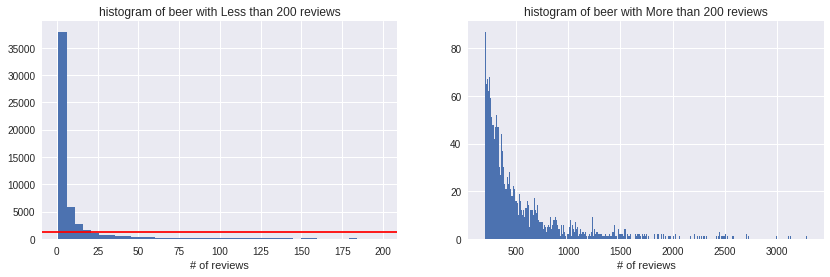

In [13]:
beer5more = freq_list_beer[np.where(freq_list_beer >= 200)]
beer5less = freq_list_beer[np.where(freq_list_beer < 200)]

plt.figure(figsize=(14, 4))

plt.subplot(121)
plt.hist(beer5less, bins=40)
plt.title('histogram of beer with Less than 200 reviews')
plt.xlabel('# of reviews')
plt.axhline(y=1200, color='r', linestyle='-')

plt.subplot(122)
plt.hist(beer5more, bins=300)
plt.title('histogram of beer with More than 200 reviews')
plt.xlabel('# of reviews')

plt.show()

### 1.3 Subset from Metadata

In [14]:
# subset data for collabrotive filtering
df1 = df[['beer_name', 'beer_beerId', 'review_profileName', 'review_overall', 'review_time']]
print('Original data size: %s' % str(df1.shape)) 

# remove NA 
df1 = df1[pd.notnull(df1.beer_name) & pd.notnull(df1.review_profileName) & pd.notnull(df1.review_overall)]
# remove blanks
df1 = df1.loc[df1.review_profileName != '']
df1 = df1.loc[df1.beer_name != '']
df1 = df1.loc[df1.review_overall != '']
print('After removing NAs and blanks: %s' % str(df1.shape)) 

# drop duplicate (beer&user) pairs, keep the latest rating
df1['beer_user_pair'] = df1.beer_name + df1.review_profileName
df1 = df1.sort_values(by=['review_time'], ascending=False).drop_duplicates(subset=['beer_user_pair'])
print('After drop duplicate user-item pairs (only keep the latest rating), data size: %s' % str(df1.shape))

# convert review ratings to numberic
df1.review_overall = pd.to_numeric(df1.review_overall)

Original data size: (1586614, 5)
After removing NAs and blanks: (1586266, 5)
After drop duplicate user-item pairs (only keep the latest rating), data size: (1561405, 6)


In [15]:
df1.head(3)

,beer_name,beer_beerId,review_profileName,review_overall,review_time,beer_user_pair
581215,Pete's Wicked Strawberry Blonde,381,bk3nj,3.0,999999652,Pete's Wicked Strawberry Blondebk3nj
1023623,Fiji Bitter,1480,Mark,4.0,999980551,Fiji BitterMark
1077899,Wolaver's India Pale Ale,399,bcm119,3.5,999903142,Wolaver's India Pale Alebcm119


#### remove bottom users and beers

In [16]:
# subset three columns
cf = df1[['review_profileName', 'beer_name', 'review_overall']]

# sort user by # of reviews
cnt_user = dict(num_review_byuser)
cf['user_freq'] = [cnt_user.get(x) for x in cf.review_profileName]

# sort beer by # of reviews
cnt_beer = dict(num_review_bybeer)
cf['beer_freq'] = [cnt_beer.get(x) for x in cf.beer_name]

# drop users with less than 10 reviews
# drop beers with less than 5 reviews
cf = cf.loc[cf.user_freq > 10]
cf = cf.loc[cf.beer_freq > 5]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [17]:
print('After removing bottom users and beers,')
print('%d unique beers;' % cf.beer_name.nunique())
print('%d unique users;' % cf.review_profileName.nunique())
print('and %d reviews in total.' % cf.shape[0])

After removing bottom users and beers,
18925 unique beers;
10189 unique users;
and 1423856 reviews in total.


In [18]:
cf.head(3)

,review_profileName,beer_name,review_overall,user_freq,beer_freq
581215,bk3nj,Pete's Wicked Strawberry Blonde,3.0,45,298
1023623,Mark,Fiji Bitter,4.0,532,8
1077899,bcm119,Wolaver's India Pale Ale,3.5,175,257


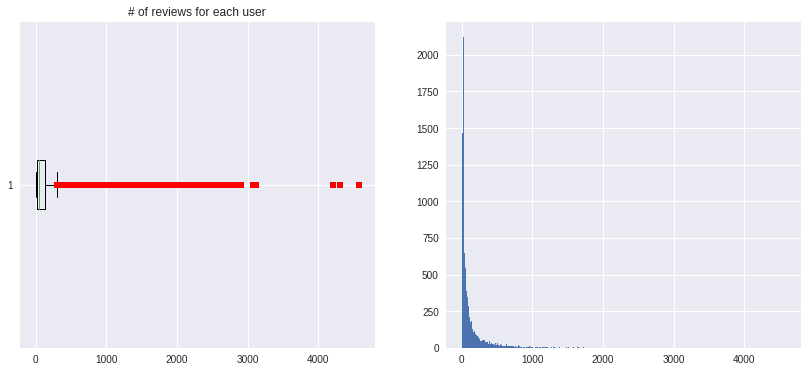

In [19]:
# user 
freq = cf.review_profileName.value_counts()
freq = np.array(list(dict(freq).values()))

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.boxplot(freq, 0, 'rs', 0)
plt.title('# of reviews for each user')

plt.subplot(122)
plt.hist(freq, bins=400)

plt.show()

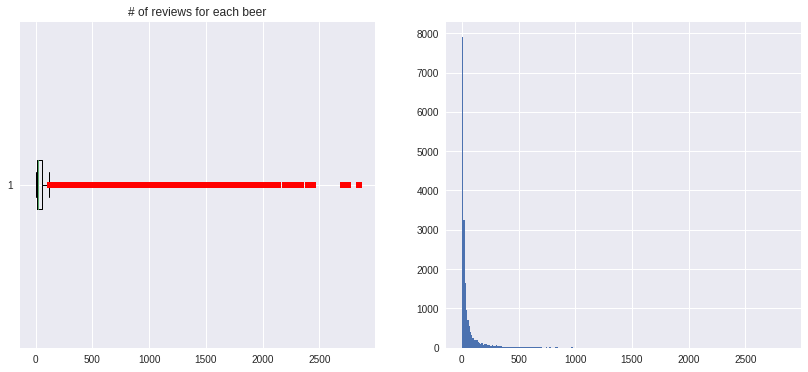

In [20]:
# beer
freqb = cf.beer_name.value_counts()
freqb = np.array(list(dict(freqb).values()))

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.boxplot(freqb, 0, 'rs', 0)
plt.title('# of reviews for each beer')

plt.subplot(122)
plt.hist(freqb, bins=250)

plt.show()

#### split into two groups
- users with more than 100 reviews;
- users with less than 100 reviews.

In [21]:
# split into two groups
threshold = 100

more = cf.loc[cf.user_freq > threshold]
less = cf.loc[cf.user_freq <= threshold]

more.head()

,review_profileName,beer_name,review_overall,user_freq,beer_freq
1023623,Mark,Fiji Bitter,4.0,532,8
1077899,bcm119,Wolaver's India Pale Ale,3.5,175,257
797362,Jason,Lindemans Framboise,3.5,2350,903
808675,Jason,Chapeau Framboise Lambic,4.0,2350,44
961766,Jason,Dooryard Ale,3.0,2350,13


group > 100 has the size: (1186781, 5)


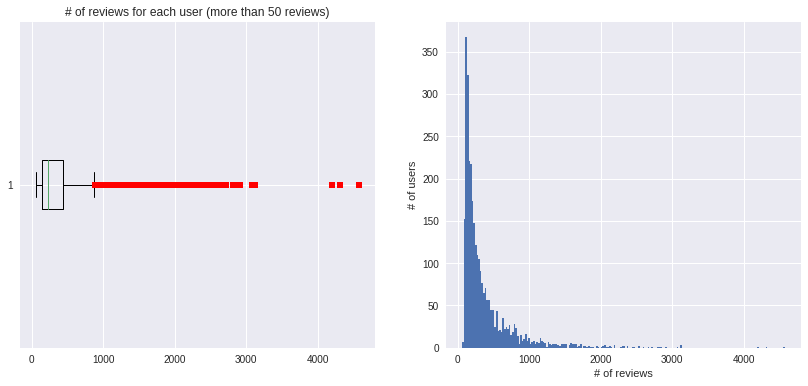

In [22]:
# visualize two groups
print('group > %d has the size: %s' % (threshold, str(more.shape)))

freqm = more.review_profileName.value_counts()
freqm = np.array(list(dict(freqm).values()))

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.boxplot(freqm, 0, 'rs', 0)
plt.title('# of reviews for each user (more than 50 reviews)')

plt.subplot(122)
plt.hist(freqm, bins=200)
plt.ylabel('# of users')
plt.xlabel('# of reviews')
plt.show()

group <= 100 has the size: (237075, 5)


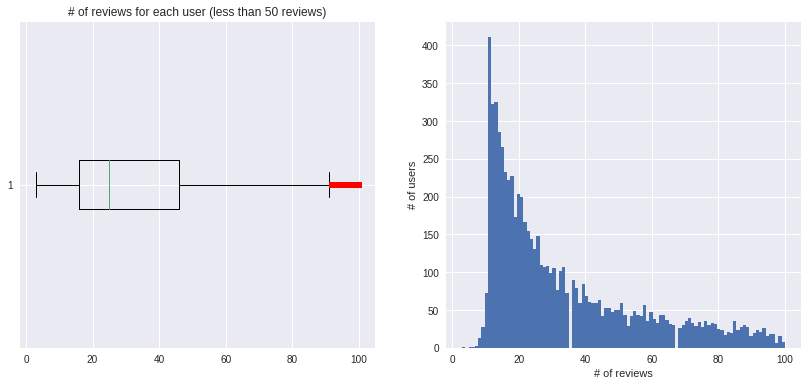

In [23]:
# visualize two groups
print('group <= %d has the size: %s' % (threshold, str(less.shape)))

freql = less.review_profileName.value_counts()
freql = np.array(list(dict(freql).values()))

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.boxplot(freql, 0, 'rs', 0)
plt.title('# of reviews for each user (less than 50 reviews)')

plt.subplot(122)
plt.hist(freql, bins=100)
plt.ylabel('# of users')
plt.xlabel('# of reviews')
plt.show()

## Part 2: Prediction Models

In [0]:
# define functions to generate prediction dataframe
# get_Iu and get_Ui are borrowed from Surprise library
def get_Iu(uid):
    """Return the number of items rated by given user
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item
    Args:
        iid: The raw id of the item.
    Returns:
        The number of users that have rated the item.
    """
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0

# customized function to get predictions
def get_pred_df(pred):
  pred_df = pd.DataFrame(pred, columns=['uid', 'iid', 'rui', 'est', 'details'])    
  pred_df['Iu'] = pred_df.uid.apply(get_Iu)
  pred_df['Ui'] = pred_df.iid.apply(get_Ui)
  pred_df['err'] = abs(pred_df.est - pred_df.rui)
  
  # append review counts
  pred_df['user_freq'] = [cnt_user.get(x) for x in pred_df.uid]
  pred_df = pred_df.sort_values(by=['uid'])
  
  return pred_df

In [0]:
# train test split
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(cf[['review_profileName', 'beer_name', 'review_overall']], reader)
trainset, testset = train_test_split(data, test_size=.33)

### 2.1 SVD

In [26]:
# fit
svd = SVD(n_factors = 30, lr_all = 0.01, reg_all = 0.05)
svd.fit(trainset)

# test 
svd_pred = svd.test(testset)
accuracy.rmse(svd_pred, verbose=True)

# predict
svd_pred_df = get_pred_df(svd_pred)
svd_pred_df.head()

RMSE: 0.5903


,uid,iid,rui,est,details,Iu,Ui,err,user_freq
310642,0110x011,Founders KBS (Kentucky Breakfast Stout),5.0,4.499652,{'was_impossible': False},99,1147,0.500348,139
7051,0110x011,Adam,4.0,4.085279,{'was_impossible': False},99,544,0.085279,139
152352,0110x011,Struise Mikkeller (Elliot Brew),4.0,4.095157,{'was_impossible': False},99,170,0.095157,139
329720,0110x011,Chez Monieux,4.5,4.180252,{'was_impossible': False},99,32,0.319748,139
300944,0110x011,Ne Goeien Saison,4.5,4.281151,{'was_impossible': False},99,48,0.218849,139


In [27]:
# predict on whole dataset
trainset_s, testset_s = train_test_split(data, test_size=.99)

svd_pred_s = svd.test(testset_s)
svd_pred_df_s = get_pred_df(svd_pred_s)
svd_pred_df_s.head()

,uid,iid,rui,est,details,Iu,Ui,err,user_freq
1267305,0110x011,Sierra Nevada Southern Hemisphere Harvest Fres...,4.5,4.225729,{'was_impossible': False},99,704,0.274271,139
1089775,0110x011,Founders Centennial IPA,4.5,4.226246,{'was_impossible': False},99,879,0.273754,139
964790,0110x011,Mirror Pond Pale Ale,4.0,4.189513,{'was_impossible': False},99,459,0.189513,139
1262334,0110x011,The Angel's Share - Bourbon Barrel-Aged,5.0,4.183541,{'was_impossible': False},99,337,0.816459,139
96140,0110x011,Mirror Mirror,4.5,4.225651,{'was_impossible': False},99,246,0.274349,139


### 2.2 Non-negative Matrix Factorization (NMF)

In [28]:
# fit
nmf = NMF(n_factors = 25, n_epochs = 50, reg_pu = 0.1, reg_qi = 0.1)
nmf.fit(trainset)

# test 
nmf_pred = nmf.test(testset)
nmf_rmse = accuracy.rmse(nmf_pred, verbose=True) 
print('Test RMSE of NMF is %s' % round(nmf_rmse, 3))

# predict
nmf_pred_df = get_pred_df(nmf_pred)
nmf_pred_df.head()

RMSE: 0.5977
Test RMSE of NMF is 0.598


,uid,iid,rui,est,details,Iu,Ui,err,user_freq
310642,0110x011,Founders KBS (Kentucky Breakfast Stout),5.0,4.525617,{'was_impossible': False},99,1147,0.474383,139
7051,0110x011,Adam,4.0,4.178880,{'was_impossible': False},99,544,0.178880,139
152352,0110x011,Struise Mikkeller (Elliot Brew),4.0,4.086247,{'was_impossible': False},99,170,0.086247,139
329720,0110x011,Chez Monieux,4.5,4.159003,{'was_impossible': False},99,32,0.340997,139
300944,0110x011,Ne Goeien Saison,4.5,4.327996,{'was_impossible': False},99,48,0.172004,139


In [29]:
# predict on whole dataset
nmf_pred_s = nmf.test(testset_s)
nmf_pred_df_s = get_pred_df(nmf_pred_s)
nmf_pred_df_s.head()

,uid,iid,rui,est,details,Iu,Ui,err,user_freq
1267305,0110x011,Sierra Nevada Southern Hemisphere Harvest Fres...,4.5,4.167958,{'was_impossible': False},99,704,0.332042,139
1089775,0110x011,Founders Centennial IPA,4.5,4.146650,{'was_impossible': False},99,879,0.353350,139
964790,0110x011,Mirror Pond Pale Ale,4.0,4.134163,{'was_impossible': False},99,459,0.134163,139
1262334,0110x011,The Angel's Share - Bourbon Barrel-Aged,5.0,4.224633,{'was_impossible': False},99,337,0.775367,139
96140,0110x011,Mirror Mirror,4.5,4.277644,{'was_impossible': False},99,246,0.222356,139


### 2.3 KNN user-based

#### 2.3.1 KNN on whole dataset (after trimmed)
Comments: although this algorithm run through, it takes up ~11GB RAM as noticed by Colab. This shows that KNN methods do not scale well for large dataset.

In [30]:
# model set up
sim_options = {'name': 'pearson', 'user_based': True, 'min_support':10}  
knnmean = KNNWithMeans(k=300, 
                       min_k=10, 
                       sim_options=sim_options, 
                       verbose=True)
# fit
knnmean.fit(trainset)

# test
knn_pred = knnmean.test(testset)

# predict
knn_pred_df = get_pred_df(knn_pred)
knn_pred_df.head()

Computing the pearson similarity matrix...
Done computing similarity matrix.


,uid,iid,rui,est,details,Iu,Ui,err,user_freq
310642,0110x011,Founders KBS (Kentucky Breakfast Stout),5.0,4.754988,"{'actual_k': 300, 'was_impossible': False}",99,1147,0.245012,139
7051,0110x011,Adam,4.0,4.397625,"{'actual_k': 275, 'was_impossible': False}",99,544,0.397625,139
152352,0110x011,Struise Mikkeller (Elliot Brew),4.0,4.262242,"{'actual_k': 90, 'was_impossible': False}",99,170,0.262242,139
329720,0110x011,Chez Monieux,4.5,4.386130,"{'actual_k': 25, 'was_impossible': False}",99,32,0.113870,139
300944,0110x011,Ne Goeien Saison,4.5,4.568688,"{'actual_k': 33, 'was_impossible': False}",99,48,0.068688,139


In [32]:
# predict whole dataset
knn_pred_s = knnmean.test(testset_s)
knn_pred_df_s = get_pred_df(knn_pred_s)
knn_pred_df_s.head()

KeyboardInterrupt: ignored

#### 2.3.2 KNN on two separate sets
Comments: beforing dropping the bottom users and beers, the dataset was too large to run on Colab and led to runtime died everytime, so we need to split the original dataset.  According to exploratory analysis above, 100 reviews is a benchmark that separate users' review_group. Thus, we split the dataset into two parts: users with more than 100 reviews and users less than 100 reviews.

Below, the result shows that this separation lead to a higher accuracy compared to the previous user-based *KNN* that used the whole dataset for training and testing. 

Note that parameters used in this section follows from previous gridsearch results. We do not include gridsearch step in this notebook, because it also takes long running time and large memory, thus not necessary/efficient to run each time we compile this notebook.

In [0]:
# set up model
sim_options = {'name': 'pearson', 'user_based': True, 'min_support':10}  
knnmean1 = KNNWithMeans(k=300, 
                       min_k=10, 
                       sim_options=sim_options, 
                       verbose=True)

knnmean2 = KNNWithMeans(k=300, 
                       min_k=10, 
                       sim_options=sim_options, 
                       verbose=True)

##### 1) users with more than 100 reviews

In [0]:
# split train & test 
knn_more = Dataset.load_from_df(more[['review_profileName', 'beer_name', 'review_overall']], reader)
trainset_more, testset_more = train_test_split(knn_more, test_size=.33)

# fit
knnmean1.fit(trainset_more)

In [0]:
# test
pred_more = knnmean1.test(testset_more)

In [0]:
# prediction
pred_more_df = get_pred_df(pred_more)
pred_more_df.head()

##### 2) users with less than 100 reviews

In [0]:
# split train & test 
knn_less = Dataset.load_from_df(less[['review_profileName', 'beer_name', 'review_overall']], reader)
trainset_less, testset_less = train_test_split(knn_less, test_size=.33)

# fit
knnmean2.fit(trainset_less)

In [0]:
# test
pred_less = knnmean2.test(testset_less)

# predict
pred_less_df = get_pred_df(pred_less)
pred_less_df.head()

### 2.4 KNN item-based
- failed twice: runtime died
- user-based collabrative filtering takes up 12GB+ RAM, reached the limits of Colab and led to kernel crach every time.

### 2.5 Text Analysis

In [0]:
# Hi Carlo: could you add the result of text analysis here? 
# or write a line like 'please refer to xxx file for model implemention'
# and add the result in the next section.

## Part 3: Model Comparison

### 3.1 Summarize model performance
(RMSE for each review_group)

In [0]:
# define function to get group prediction error
def error_bygroup(pred_df, model_name):
  """
  input complete pred_error df
  output pred_error by group
  """
  # cut into groups
  bins = [10, 20, 30, 40, 50, 100, 200, 500, 1000, 2000, 6000]
  labels = ['11-20', '21-30', '31-40', '41-50', '51-100', '101-200', 
            '201-500', '501-1000', '1001-2000', '2001-6000']
  
  # add group label
  pred_df['review_group'] = pd.cut(pred_df['user_freq'], bins = bins, labels = labels)
  
  # calculate group mean
  pred_df = pred_df.groupby('review_group').mean()
  
  # rename the error column
  #pred_df['err'].columns = model_name
  pred_df = pred_df.rename(columns = {'err':model_name})
  return pred_df

In [0]:
# get prediction error
#knn_pred_df = pd.concat([pred_more_df, pred_less_df])
svd_err = error_bygroup(svd_pred_df_s, 'SVD')
nmf_err = error_bygroup(nmf_pred_df_s, 'NMF')

In [0]:
knn_err_separate = error_bygroup(knn_pred_df, 'KNN_separate')
knn_err = error_bygroup(knn_pred_df_s, 'KNN')

In [54]:
svd_err

,rui,est,Iu,Ui,SVD,user_freq
review_group,,,,,,
11-20,3.875481,3.867062,10.070905,485.129422,0.484431,15.274817
21-30,3.867254,3.862488,16.442874,477.363811,0.471598,25.157882
31-40,3.871833,3.867057,22.863873,476.778657,0.450370,35.311422
41-50,3.851476,3.854339,29.501952,469.811385,0.453885,45.463247
51-100,3.861771,3.858314,48.729359,464.356644,0.440394,74.963438
101-200,3.847301,3.845896,96.013768,438.565813,0.428011,148.601509
201-500,3.821136,3.818217,216.506099,385.283131,0.425643,337.717153
501-1000,3.801014,3.802677,455.234346,322.563125,0.415073,724.031583
1001-2000,3.771071,3.773976,858.060679,250.665478,0.429682,1424.596494


In [0]:
# combine three models
final = pd.concat([svd_err['SVD'], nmf_err['NMF'], knn_err['KNN'], 
                   knn_err_separate['KNN_separate']], axis=1)
final

According to the error matrix above, using two separate groups in KNN will significantly improve model accuracy (column 3 and 4). However, for the purpose of compare model performance over all review groups, we will use the result of 'KNN on whole dataset' for comparison in the following plots.

### 3.2 Visualize

In [0]:
# visualize
x = [20, 30, 40, 50, 100, 200, 500, 1000, 2000, 6000]
y_svd = svd_err['SVD'].values.tolist()
y_nmf = nmf_err['NMF'].values.tolist()
y_knn = knn_err['KNN'].values.tolist()

plt.plot(x, y_svd, '.r-') 
plt.plot(x, y_nmf, '.b-') 
plt.plot(x, y_knn, '.g-') 
plt.legend(('SVD', 'NMF', 'KNN'), loc='upper right')

plt.xlabel('number of reviews')
plt.ylabel('test rmse')
plt.title('Compare model performance over different # of reviews')

plt.show()

According to the plot above, *KNN* has the best performance for review_group (50, 2000], while *NMF* outperforms *KNN* when the number of reviews exceeds 2000. *SVD* seem to be the least favorite model among the three.

In [0]:
# visualize: reviews 10-200

x = [20, 30, 40, 50, 100, 200]
y_svd = svd_err['SVD'].values.tolist()[:6]
y_nmf = nmf_err['NMF'].values.tolist()[:6]
y_knn = knn_err['KNN'].values.tolist()[:6]

plt.plot(x, y_svd, '.r-') 
plt.plot(x, y_nmf, '.b-') 
plt.plot(x, y_knn, '.g-') 
plt.legend(('SVD', 'NMF', 'KNN'), loc='upper right')

plt.xlabel('number of reviews')
plt.ylabel('test rmse')
plt.title('Compare model performance over different # of reviews (0~200)')

plt.show()

Using a zoom in view, we look at review_group between (10, 200). It becomes clear that *KNN* works the best after ~70 reviews but performs significantly poorly from (10, 70]. According to this plot, we are safe to say that *KNN* is not a good choice for cold start problem, i.e. number of reviews under 50.

## Part 4: Example Recommendation
We randomly choose 20 users from the whole dataset (2 from each review_group) to illustrate how our recommendation system works.


#### 4.1 Choose 20 users

In [52]:
user20 = svd_pred_df_s[['uid', 'review_group']].drop_duplicates('uid').sort_values(by='review_group')

# first 10 users
user10 = user20.drop_duplicates('review_group', keep='first')
# 11-20 users
user11 = user20.drop_duplicates('review_group',keep='last')
# combine 
users = pd.concat([user10, user11], axis=0).sort_values(by='review_group')
users

,uid,review_group
1369326,bronco94,11-20
33450,t8s8l8,11-20
678079,kkrez,21-30
1234027,SERENGETI,21-30
84785,uabigdaz,31-40
502602,dmbfrat420beers,31-40
178751,Graham21,41-50
1174034,Roderick,41-50
827969,linnet,51-100
315493,clarkm04,51-100


In [57]:
user20_names = users.uid.tolist()
user20_names

['bronco94',
 't8s8l8',
 'kkrez',
 'SERENGETI',
 'uabigdaz',
 'dmbfrat420beers',
 'Graham21',
 'Roderick',
 'linnet',
 'clarkm04',
 'nickynick',
 'jdoncbus',
 'cavedave',
 'JohnnyDuvel',
 'craytonic',
 'Phelps',
 'rastaman',
 'twiggamortis420',
 'mikesgroove',
 'weeare138']

#### 4.2 extract their predictions from SVD

In [0]:
# this is the SVD prediction (recommendations for each user)
svd_pred_s

In [0]:
# NMF prediction
nmf_pred_s

In [0]:
# KNN prediction (if it runs through)
knn_pred_df_s